<a href="https://colab.research.google.com/github/GZR1996/deep-learning/blob/master/week5/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 lab: Inverse & Ill-posed problems, and Regularisation

This week we will get some hands-on experience with inverse problems

Some of the content from this lab builds on Chollet's ([work](https://github.com/fchollet/deep-learning-with-python-notebooks)) 

Inverse problems are a wide class of mathematical problems which arise when we wish to compute information about internal or hidden data from outside measurements.  These are at the core of science – making observations of the world and trying to infer what that means about the state of the world, given what we know of how the observations were generated and observed. They are also members of the class of ill-posed problems (a term coined in the early 20th century by Hadamard.
A quite generic formulation:  
$$\int_\Omega I \times S \, d\Omega = O$$

**Ill-posed example: 1-D Image Restoration**

Kernel $K$: a point spread function for an infinitely long slit of width
one wavelength. Independent variables $t$ and $s$ are the angles of the incoming
and scattered light. This code is adapted from MATLAB to Python - for the original see P. C. Hansen's  MATLAB Regularization Tools: [shaw](https://uk.mathworks.com/matlabcentral/fileexchange/52-regtools).

$$K(s,t) = (\cos(s) + \cos(t))^2 \frac{\sin(u)}{u}^2$$
$$u =\pi (\sin(s) + \sin(t))$$
$$\int_{-\pi/2}^{\pi/2} K(s,t) f (t) dt = g(s) ,  \quad−\pi/2 ≤ s ≤ \pi/2$$

In [0]:
import numpy as np
import math

def shaw(n):
    # SHAW Test problem: one-dimensional image restoration model.
    #
    # [A,b,x] = shaw(n)
    # 
    # Discretization of a first kind Fredholm integral equation with
    # [-pi/2,pi/2] as both integration intervals.  The kernel K and
    # the solution f, which are given by
    #    K(s,t) = (cos(s) + cos(t))*(sin(u)/u)^2
    #    u = pi*(sin(s) + sin(t))
    #    f(t) = a1*exp(-c1*(t - t1)^2) + a2*exp(-c2*(t - t2)^2) ,
    # are discretized by simple quadrature to produce A and x.
    # Then the discrete right-hand b side is produced as b = A*x.
    #
    # The order n must be even.
    # Reference: C. B. Shaw, Jr., "Improvements of the resolution of
    # an instrument by numerical solution of an integral equation",
    # J. Math. Anal. Appl. 37 (1972), 83-112.
    # Per Christian Hansen, IMM, 08/20/91.
    # Check input.
    if (n % 2 !=0):
        print('The order n must be even')
        return
    
    # Initialization.
    h = math.pi/n; 
    A = np.zeros((n,n));
    # Compute the matrix A.
    xrange = np.arange(0.5,n+0.5)
    co = np.cos(-math.pi/2.0 + np.dot(xrange,h))
    psi = math.pi*np.sin(-math.pi/2.0  + np.dot(xrange,h))
    for i in range(0,n//2):
        for j in range(i,n-i):
            ss = psi[i] + psi[j]
            A[i,j] = ((co[i] + co[j])*np.sin(ss)/ss)**2
            A[n-j-1,n-i-1] = A[i,j]
        A[i,n-i-1] = (2.0*co[i])**2
    A = A + np.transpose(np.triu(A,1))
    A = np.dot(A,h)
    
    # Compute the vectors x and b.
    a1 = 2.0
    c1 = 6.0
    t1 =  .8
    a2 = 1.0
    c2 = 2.0
    t2 = -.5
    x = a1*np.exp(-c1*(-math.pi/2 + np.dot(np.transpose(xrange),h) - t1)**2) + a2*np.exp(-c2*(-math.pi/2 + np.dot(np.transpose(xrange),h) - t2)**2)
    b = np.dot(A,x)

    return (A,b,x)

OK, let's try using $n=24$ and see what we get out. Remember $A$ would be the forward model, and we would observe $b$ in measurements. We would then want to try to infer the $x$ that caused that observation.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 0.92, '$A$ matrix')

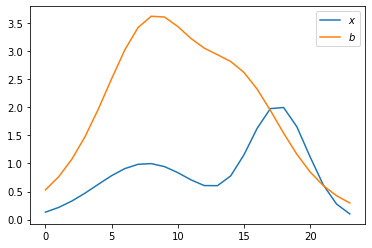

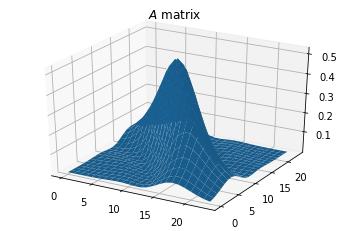

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


(A,b,x) = shaw(24)

fig1 = plt.figure()
plt.plot(x)
plt.plot(b)
plt.legend(['$x$','$b$'])

(X,Y) = np.meshgrid(range(0,np.shape(A)[0]), range(0,np.shape(A)[1]))
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,A)
plt.title('$A$ matrix')

So let us try the most simple method, multiple by $A^{-1}$. What happens?

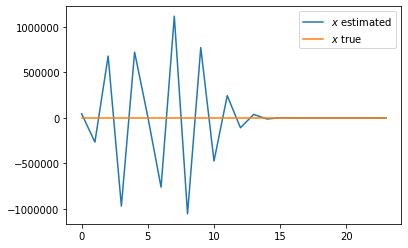

In [0]:
x_est = np.dot(np.linalg.inv(A), b)

fig = plt.figure()
plt.plot(x_est)
plt.plot(x)
plt.legend(['$x$ estimated', '$x$ true'])

The answer was so far off we can't even see the structure of the true function.  Let's have a look at the singular value decomposition of the matrix $A$.


Text(0.5, 1.0, 'Singular values')

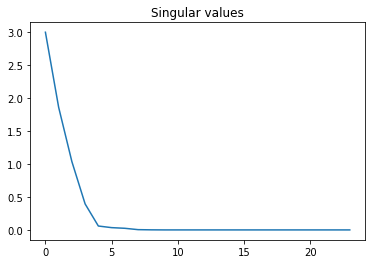

In [0]:
(U,S,VH) = np.linalg.svd(A, full_matrices=False) # compute a compact SVD
plt.figure()
plt.plot(S)
plt.title('Singular values')

Note that after about the 5th singular value, they are very close to zero, and we can't see much detail in the lower values, so let's look at this in the log domain:

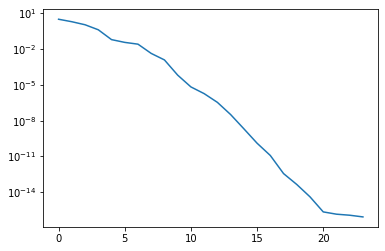

In [0]:
plt.figure()
plt.semilogy(S)

You might also be interested in the singular vectors $U_i$. Note that the singular vectors (which you can also think of as eigenvectors) associated with the largest singular values (i.e. there is most of the 'energy' representing the figure in them) are the smoothest. The singular vectors go progressively from smooth, low-frequency functions towards more oscillatory, higher-frequency functions. 

The “smoother” the kernel $K$, the faster the $s_i$ decay to zero. This means that the higher frequencies are damped more than lower frequencies in the forward problem. This can also be called *'smoothing'*.


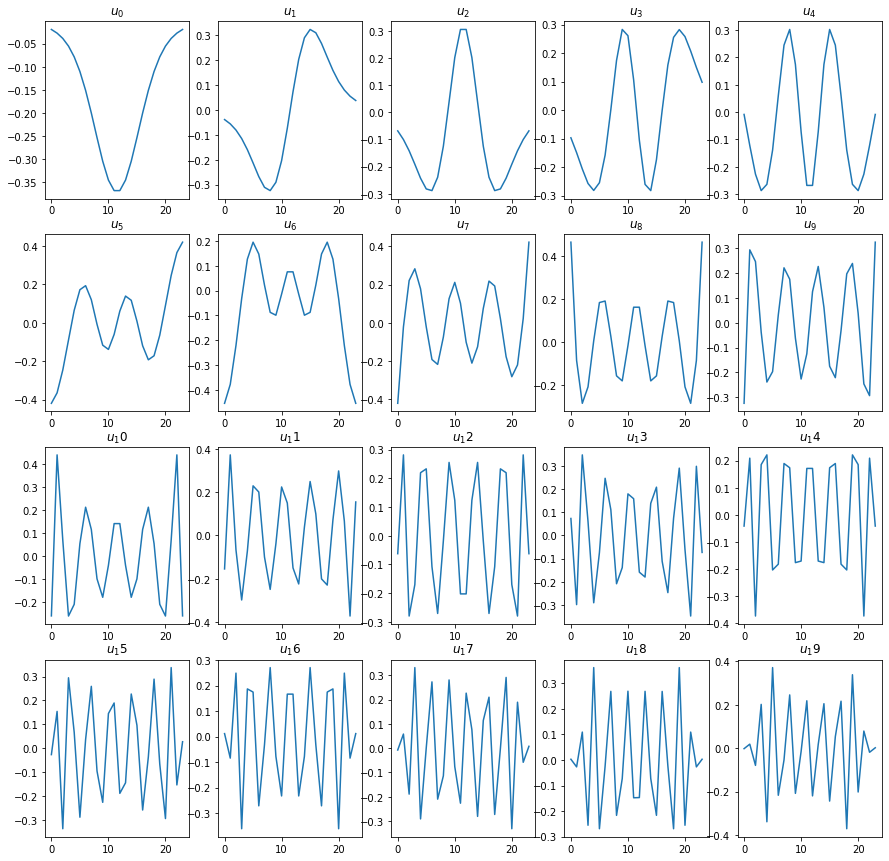

In [0]:
plt.figure(figsize=(15,15))
for i in range(0,20):
    plt.subplot(4,5,i+1)
    plt.plot(U[:,i])
    plt.title('$u_'+str(i)+'$')

Now remember that as we can represent a matrix $A = U S V^H$, then its pseudo-inverse $A^{+} = V S^{+}U^H$, and $S^{+}$ will be a diagonal matrix with entries $\frac{1}{s_i}$, where the $s_i$ are the  nonzero singular values we plotted above. As they get very small, what happens to their reciprocal? Does that explain why we had an estimate of $x$ that was so large?

In [0]:
x_est_direct = np.dot(np.dot(np.dot(np.transpose(np.conjugate(VH)),np.diag(1.0/S)), np.transpose(np.conjugate(U))), b)

Struncinv= np.zeros(np.shape(S))
cut_off = 6
Struncinv[0:cut_off] = 1.0/S[0:cut_off]
x_est_tsvd = np.dot(np.dot(np.dot(np.transpose(np.conjugate(VH)),np.diag(Struncinv)), np.transpose(np.conjugate(U))), b)


plt.figure()
plt.plot(x)
plt.plot(x_est_direct)
plt.legend(['$x_{true}$','$x_{est}$'])

plt.figure()
plt.plot(x)
plt.plot(x_est_tsvd)

plt.legend(['$x_{true}$','$x_{tsvd}$',])

Now this is better, but still not perfect. Things also get worse if we have some small measurement error on the $b$ values.

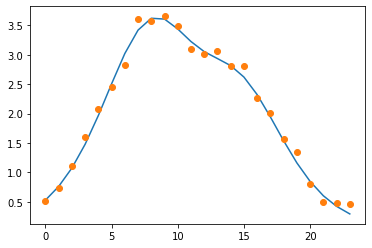

In [0]:
b_err = b + np.random.normal(scale=0.1, size=np.shape(b))


plt.figure()
plt.plot(b)
plt.plot(b_err,'o')

Let's try TSVD. Play with different `cut_off` values.

Text(0.5, 1.0, 'truncated SVD on noisy observations')

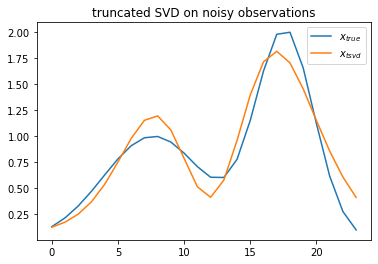

In [0]:
Struncinv= np.zeros(np.shape(S))
cut_off = 4
Struncinv[0:cut_off] = 1/S[0:cut_off]
x_est_tsvd = np.dot(np.dot(np.dot(np.transpose(np.conjugate(VH)),np.diag(Struncinv)), np.transpose(np.conj(U))), b_err)

plt.figure()
plt.plot(x)
plt.plot(x_est_tsvd)

plt.legend(['$x_{true}$','$x_{tsvd}$',])
plt.title('truncated SVD on noisy observations')

And now we can try filtering the singular values with a Tikhonov approach. Experiment with changing `lamb`

Text(0.5, 1.0, 'Ridge regression on noisy observations')

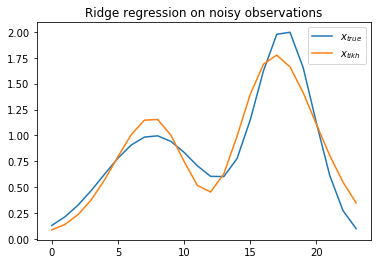

In [0]:
lamb = 0.15
psi = np.divide(S**2,S**2+lamb**2) # Tikhonov filter factors       
x_est_tikh = np.dot(np.dot(np.dot(np.transpose(np.conjugate(VH)), np.diag(np.multiply(psi,(1/S)))), np.transpose(np.conj(U))), b_err)

plt.figure()
plt.plot(x)
plt.plot(x_est_tikh)

plt.legend(['$x_{true}$','$x_{tikh}$',])
plt.title('Ridge regression on noisy observations')

In [0]:
def  picard(U,s,b,d=0):
    # PICARD Visual inspection of the Picard condition.
    #
    # eta = picard(U,s,b)
    # eta = picard(U,s,b,d)
    # eta = picard(U,sm,b)    ,  sm = [sigma,mu]
    # eta = picard(U,sm,b,d)
    #
    # Plots the singular values, s(i), the abs. value of the Fourier
    # coefficients, |U(:,i)'*b|, and a (possibly smoothed) curve of the
    # solution coefficients eta(i) = |U(:,i)'*b|/s(i).  U and s must be
    # computed by the function csvd.
    #
        # If s = [sigma,mu], where gamma = sigma./mu are the generalized
    # singular values, then this routine plots gamma(i), |U(:,i)'*b|,
    # and (smoothed) eta(i) = |U(:,i)'*b|/gamma(i).  U and sm must be
    # computed by the function cgsvd.
    #
    # The smoothing is a geometric mean over 2*d+1 points centered at point #i.
    # If nargin = 3, then d = 0 (i.e, no smoothing).
    # Reference: P. C. Hansen, "The discrete Picard condition for discrete
    # ill-posed problems", BIT 30 (1990), 658-672.
    # Per Christian Hansen, DTU Compute, July 20, 2012.
    # Initialization.

    s = np.expand_dims(s, axis=1)
    b = np.expand_dims(b, axis=1)
    
    (n,ps) = np.shape(s)
    
    beta = np.absolute(np.dot(np.transpose(U[:,0:n]), b))
    eta  = np.zeros((n,1))

    if (ps==2):
        s = np.divide(s[:,1],s[:,2])
    
    d21 = 2*d+1
    keta = np.arange(1+d,n-d)
      
    if not np.all(s):
        print('Division by zero singular values')
        return
    
    for i in keta:
         eta[i]= np.prod(beta[range(i-d,i+d)]**(1/d21))/s[i]

    
    # Plot the data.
    xrange = np.arange(1,n+1)

    plt.figure()
    plt.semilogy(xrange,s,'.-', xrange, beta,'.', keta, eta[keta],'o')
    plt.xlabel('i')
    plt.title('Picard plot')
    if (ps==1):
      plt.legend(['$\sigma_i$','$|u_i^Tb|$','$|u_i^Tb|/\sigma_i$'])
    else:
      plt.legend(['$\sigma_i/\mu_i$','$|u_i^Tb|$','$|u_i^Tb| / (\sigma_i/\mu_i)$', 'Location','NorthWest'])
 
                             
    return eta

The *Picard condition* is that in order that there exists a square integrable solution $f$ to the integral equation, the right-hand side $g$ must satisfy
$$||f||_2^2= \int_0^1 f(t)^2dt = \sum_{i=1}^\infty \left(\frac{u_i^T g_i}{s_i}\right)^2 < \infty,  g \in \text{range}(K).$$
In plain words: the absolute value of the coefficients $|u_i^T g|$ must *decay* faster than the singular values $s_i$ (a condition on the smoothness of the right hand side $g(s)$. (Note it is decay, not absolute value that matters)

We can view the Picard plots for any system we have already taken the SVD of and where we have the observations $b$.


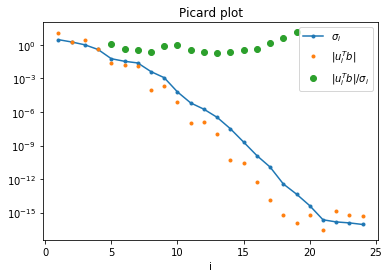

In [0]:
eta = picard(U,S,b,4)

Note how the coefficients $|u_i^Tb|$ stop decreasing as they reach the machine precision threshold (from about 20 on)

How do things change if we look at the Picard plot for the system with noisy observations $b_{err}$?

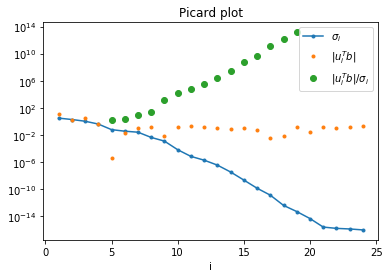

In [0]:
eta = picard(U,S,b_err,4)

Now we can see the $|u_i^Tb|$ start to decay more slowly than the $\sigma_i$ much earlier, showing the impact of observation errors on the situation.

Let's look at fitting a polynomial to some data.
$$y(x) = \sum_{i=1}^n w_i x^i,$$
and then fitting that by optimising a cost function which has been augmented with a preference for a smaller $l_2$ norm
$$J(w) = MSE_{train}+ \lambda w^t w$$

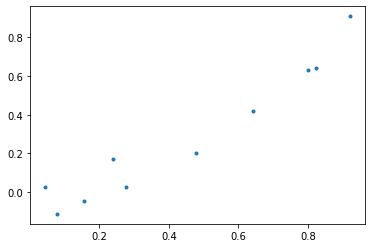

In [0]:
import numpy as np

N = 10
x = np.random.uniform(size= [N,1], low=0.0,high=1.0)
y = x**2+np.random.normal(size= [N,1], scale= 0.1)

plt.figure()
plt.plot(x,y,'.')

Try different orders of polynomial $n$,  and then different values of `lamb`.

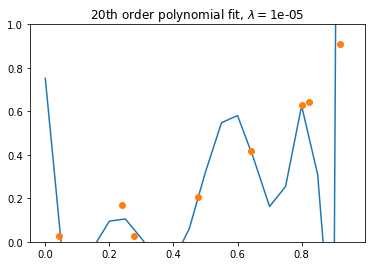

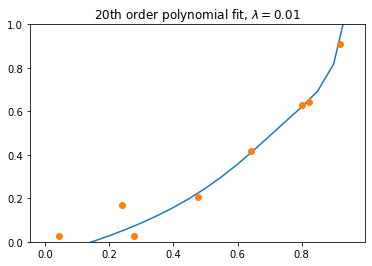

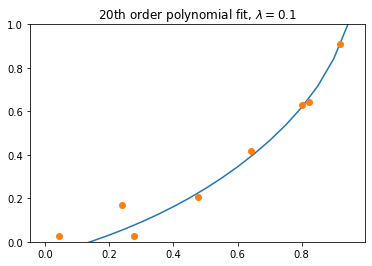

In [0]:
n = 20        # order of polynomial
lamb = 0.001  # value of regularisation parameter

A = np.zeros((N,n+1))
for i in range(0,N):
  for j in range(0,n+1):
    A[i,j] = x[i]**j
    
#let's find optimal fit

(U,S,VH) = np.linalg.svd(A, full_matrices=False)


for lamb in [0.00001, 0.01, 0.1]:
    psi = np.divide(S**2,S**2+lamb**2) # Tikhonov filter factors
    w_est = np.dot(np.dot(np.dot(np.transpose(np.conjugate(VH)), np.diag(np.multiply(psi,(1/S)))), 
                          np.transpose(np.conj(U))),
                   y)

    xrange = np.arange(0,1,0.05)
    Ntest = np.shape(xrange)[0]
    Atest = np.zeros((Ntest,n+1))
    for i in range(0,Ntest):
      for j in range(0,n+1):
        Atest[i,j] = xrange[i]**j
        
    plt.figure()
    plt.plot(xrange,np.dot(Atest, w_est),'-')
    plt.plot(x,y,'o')
    plt.ylim((0,1))
    plt.title(str(n)+'th order polynomial fit, $\lambda=$'+str(lamb))